### this is my notebook for trying to figure out how to make medical history information into something useful

#### first we import libraries and data

In [204]:
import pandas as pd
import numpy as np

import os
import re
from collections import Counter

import re

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import random as rn

from IPython.display import clear_output


In [192]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data'

In [205]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'

In [206]:
clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [207]:
clin.shape

(165433, 121)

#### then we load up my helper functions

In [208]:

def show_confusion_matrix2(confusion_matrix, labels):
    LABELS = labels

    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, cmap = 'Blues', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 15});
    plt.title("Confusion matrix", fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()
    
def get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False):
    
    y_test = targets.numpy()
    
    f1_w = sklearn.metrics.f1_score(y_test, predictions, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, predictions, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, predictions)
    prec = sklearn.metrics.precision_score(y_test,predictions, average=None) 
    rec = sklearn.metrics.recall_score(y_test,predictions, average=None)
    auroc = sklearn.metrics.roc_auc_score(y_test,preds[:,1], average=None)
    confusion = sklearn.metrics.confusion_matrix(y_test, predictions)
    
    tp, fn, fp, tn = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]
    
    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    
    
    if print_output:
        print ('Metrics Report:')
        print ('---------------')
        print ('weighted f1: ', f1_w)
        print ('AUROC:       ',auroc)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        print ('sensitivity: ', sens)
        print ('specificity: ', spec)
        print ('PPV:         ', ppv)
        print ('NPV:         ', npv)
        
    if show_confusion:
        show_confusion_matrix2(confusion, labels = data.classes)
     
    if return_values == True:
        return f1_w, auroc, acc, sens, ppv



#### then we clean up the data in the medical history column

In [209]:
history = list(clin['MedicalHistory'].str[16:].astype('str'))

In [210]:
#this is to clean the text in the medical history column (a little bit)
def fixhx(s):
    s =s.replace('<LT><LF>','')
    s = s.replace('<LT>LF>','')
    s =s.replace('Pt.', 'patient')
    s =s.replace('Pt', 'patient')
    s = s.lower()
    s = s.replace('pt.', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('sob', 'shortness of breath')
    s = s.replace('c/p', 'chest pain')
    s = s.replace('hrs', 'hours')
    s = s.replace('hx', 'history')
    s = s.replace('n/v', 'nausea and/or vomiting')
    s = s.replace('a/e', 'air entry')
    s = s.replace('a/o', 'alert and oriented')
    s = s.replace('a&o', 'alert and oriented')
    s = s.replace('d/c', 'discharge')
    s = s.replace('u/s', 'ultrasound')
    s = s.replace('yrs', 'years')
    s = s.replace('lmp', 'last menstrual period')
    s = s.replace('w/', 'with')
    s = s.replace('@', 'at ')
    s = s.replace('b/c', 'because')
    s = re.sub(r'\bpt.','patient ',s)
    s = re.sub(r'\blt.','left ',s)
    s = re.sub(r'\brt.','right ',s)
    s = re.sub(r'\bmd.','doctor ',s)
    s = re.sub(r'\bra\b','room air ',s)
    s = re.sub(r'\bbp.','blood pressure ',s)
    s = re.sub(r'\bcp.','chest pain ',s)
    s = re.sub(r'\bfd.','family doctor ',s)
    s = s.replace('abx', 'antibiotics')
    s = s.replace(' htn ', ' hypertension ')
    s = re.sub(r'\btyl\b', 'tylenol', s)
    s = re.sub(r'\bprn\b', 'as needed ',s)
    s = re.sub(r'\bvag\b', 'vaginal ',s)
    s = re.sub(r'\bpo\b', 'by mouth ',s)
    s = re.sub(r'\bllq\b', 'left lower quadrant',s)
    s = re.sub(r'\brlq\b', 'right lower quadrant  ',s)
    s = re.sub(r'\bluq\b', 'left upper quadrant',s)
    s = re.sub(r'\bruq\b', 'right upper quadrant  ',s)
    s = re.sub(r'\buti\b', 'urinary tract infection ',s)
    s = re.sub(r'\brd', 'right digit number',s)
    s = re.sub(r'\bld', 'left digit number',s)
    s = re.sub(r'\br\b', 'right ',s)
    s = re.sub(r'\bl\b', 'left ',s)
    s = re.sub(r'\bed\b', 'emergency department ',s)
    s = re.sub(r'\ber\b', 'emergency room ',s)
    s = re.sub(r'\bbm\b', 'bowel movement ',s)
    s = re.sub(r'#\s', 'fracture ', s)
    
    #remove extra white spaces
    s = re.sub(r'\s+', ' ', s)

    #note that what's missing here is removal of punctuation
    return s

In [211]:
replacements = (',','<LT>LF>', '.')
drop_list = ('"', '?')
split_hist = []
for item in history:
    for r in replacements:
        item = item.replace(r, '::')
    
    item = item.split('::')
    
    item = [re.sub(r'\(.*?\)\ *', '', s) for s in item]
    
    item = [fixhx(s) for s in item]
    for d in drop_list:
        item = [x.replace(d,'') for x in item]
    
    item = [x.strip().lower() for x in item if x != 'nan']
    item = [x for x in item if len(x) > 2]
    
    item = list(filter(None, item))
    
    split_hist.append(item)
    

In [212]:
#split hist is a list of lists, where each entry is the list of past medical history conditions for each patient
split_hist[:20]

[['no significant medical history'],
 ['no significant medical history'],
 ['no significant medical history'],
 ['dialysis haemo/pd', 'iddm', 'crf', 'heart problem', 'high cholesterol'],
 ['fibromyalgia'],
 ['enlarged liver'],
 ['anxiety', 'autistic', 'adhd', 'depression', 'asthma', 'celiac'],
 ['no significant medical history'],
 ['hypothyroid'],
 ['anxiety'],
 ['no significant medical history'],
 ['hypertension'],
 ['arthritis', 'copd'],
 ['itp', 'wiscott-aldridge syndrome', 'eczema'],
 ['suicidal attempts', 'depression'],
 ['high cholesterol',
  'hypertension',
  'niddm',
  'cabg',
  'left knee surgery 15 years ago'],
 ['sepsis',
  'urinary tract infection',
  'ca lungs',
  'ca bronchus',
  'hypothyroid',
  'glaucoma cataract/cataract repair',
  'kidney disease',
  'anemia'],
 ['alcoholism'],
 ['gerd', 'high cholesterol'],
 ['hypertension',
  'tia',
  'osteoporosis',
  'diverticulitis',
  'high cholesterol',
  'anxiety',
  'depression',
  'aortic stenosis']]

In [213]:
#creates a list of the number of comborbid conditions of each patient
comorbids = [len(item) if item != ['no significant medical history'] else 0 for item in split_hist]

In [214]:
#rejoining them as a string with diagnoses separated by spaces
join_hist = [' '.join(item) for item in split_hist]

#replacing empty string with NaN
join_hist = [np.nan if item == 'nan' else item for item in join_hist]

len(join_hist)

165433

In [215]:
#join hist converts each patients medical history into a single string with diagnoses separated by commas
join_hist[:20]

['no significant medical history',
 'no significant medical history',
 'no significant medical history',
 'dialysis haemo/pd iddm crf heart problem high cholesterol',
 'fibromyalgia',
 'enlarged liver',
 'anxiety autistic adhd depression asthma celiac',
 'no significant medical history',
 'hypothyroid',
 'anxiety',
 'no significant medical history',
 'hypertension',
 'arthritis copd',
 'itp wiscott-aldridge syndrome eczema',
 'suicidal attempts depression',
 'high cholesterol hypertension niddm cabg left knee surgery 15 years ago',
 'sepsis urinary tract infection ca lungs ca bronchus hypothyroid glaucoma cataract/cataract repair kidney disease anemia',
 'alcoholism',
 'gerd high cholesterol',
 'hypertension tia osteoporosis diverticulitis high cholesterol anxiety depression aortic stenosis']

### exploring different diagnoses

In [216]:
diagnoses = Counter()
for hx in split_hist:
    for item in hx:
        diagnoses[item] += 1

In [217]:
#there are 23721 different medical histories used in the dataset!!!
len(diagnoses)

23721

In [218]:
#sorted diagnoses
diagnoses.most_common(40)

[('no significant medical history', 73713),
 ('hypertension', 21703),
 ('high cholesterol', 19767),
 ('niddm', 12394),
 ('htn', 7693),
 ('asthma', 6974),
 ('high bp', 6399),
 ('depression', 6375),
 ('thyroid', 4936),
 ('anxiety', 4855),
 ('hypothyroid', 3981),
 ('iddm', 3800),
 ('gerd', 3409),
 ('diabetes', 3257),
 ('acid reflux', 2420),
 ('arthritis', 2220),
 ('anemia', 1706),
 ('copd', 1511),
 ('high chol', 1283),
 ('chf', 1172),
 ('schizophrenia', 1154),
 ('gout', 1120),
 ('seizure', 1057),
 ('kidney stones', 1021),
 ('enlarged prostate', 1016),
 ('cva', 1011),
 ('atrial fibrillation', 952),
 ('dementia', 924),
 ('cholesterol', 893),
 ('migraines', 874),
 ('adhd', 794),
 ('osteoporosis', 784),
 ('bipolar', 723),
 ('chronic back pain', 717),
 ('afib', 716),
 ('immunizations up to date', 688),
 ('smoker', 675),
 ('cad', 624),
 ('fibromyalgia', 601),
 ('substance misuse', 597)]

In [219]:
diagnoses.most_common()[-40:]

[('tear in aorta', 1),
 ('vertebra fracture', 1),
 ('ulcers both feet', 1),
 ('wallerian degenration', 1),
 ('hemiplegia at birth', 1),
 ('ventricular enlargement', 1),
 ('myocaridial infarction five years ago', 1),
 ('stroke fifteen years ago', 1),
 ('bilateral lung transplant', 1),
 ('copa syndrome', 1),
 ('cellulitis developed from c-section', 1),
 ('low hg-blood transfusion 3months ago', 1),
 ('back injury -high chol', 1),
 ('hashimotos-auto immune ds', 1),
 ('prolactin level high-', 1),
 ('stent-heart blockage', 1),
 ('torn ligament of left leg', 1),
 ('bilateral lower leg amputations', 1),
 ('currently being assessed for delirium', 1),
 ('stent 9 months ago', 1),
 ('legs paralyed', 1),
 ('5 tetnts 2018', 1),
 ('carotid sx', 1),
 ('demyleanating neuropathy', 1),
 ('paresthesia', 1),
 ('type ii diabetes', 1),
 ('unspecified heart disease', 1),
 ('list', 1),
 ('c6 stenosis', 1),
 ('left femur fracture three years ago', 1),
 ('abaltion st', 1),
 ('mikes on march 26', 1),
 ('select fr

In [220]:
#this turns the num_diagnoses of classes into a dict where each class has a number
#this assumes the counter has already been made
#this also assumes the medical history has already been split into a list of diagnoses

def multihot_encode(counter, split_hist, num_diagnoses):
    class_dict = {finding[0]:i for i,finding in enumerate(counter.most_common(num_diagnoses))}

    #this creates a large array containing a 1 in each column where there is a diagnosis
    complete_findings = np.empty((len(split_hist), len(class_dict)+1))
    for idx,findings in enumerate(split_hist):
        findings_array = np.zeros(len(class_dict)+1)
        for finding in findings:
            try:
                findings_array[class_dict[finding]] = 1
            except:
                findings_array[len(class_dict)] = 1
        complete_findings[idx,:]= findings_array

    complete_findings.shape

    #this turns the above array into a dataframe
    findings_df = pd.DataFrame(complete_findings.astype(int), columns = list(class_dict.keys()) + ['other'])
    print (f'There are {num_diagnoses} diagnoses, {findings_df.shape[1] - num_diagnoses} unknowns and {len(findings_df)} patients in the encoded dataframe')
    return findings_df

In [159]:
small_findings = multihot_encode(diagnoses, split_hist, 1000)

There are 1000 diagnoses, 1 unknowns and 165433 patients in the encoded dataframe


In [120]:
#small_findings.to_csv(data_path + '/top_1000_pmhx.csv', index = False)

### now to try using these features to train a tabular fast.ai model

In [221]:
from fastai import *
from fastai.tabular import *

import random

from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#### 1000 patients, 1000 diagnoses

In [222]:
small_findings = multihot_encode(diagnoses, split_hist, 1000)

small_findings['discharge'] = clin['discharge']

There are 1000 diagnoses, 1 unknowns and 165433 patients in the encoded dataframe


In [223]:
test_df = small_findings.sample(1000)

test_df.shape

(1000, 1002)

In [224]:
cat_names = list(test_df.columns)[:-1]
dep_var = 'discharge'  

procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_df.copy(), cat_names=cat_names)

data = (TabularList.from_df(test_df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())


In [225]:
layers = [100,50]
epochs = 10
lr = 5e-2 

In [226]:
print ('1000 patients, 1000 diagnoses')
learn = tabular_learner(data, layers, metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)


1000 patients, 1000 diagnoses


epoch,train_loss,valid_loss,accuracy,time
0,0.686499,0.496069,0.940000,00:05
1,0.547316,0.499063,0.940000,00:05
2,0.463969,9.111872,0.940000,00:05
3,0.400833,7.391672,0.940000,00:04
4,0.349066,8.863023,0.940000,00:04
5,0.316807,0.904135,0.940000,00:05
6,0.293682,10.918314,0.060000,00:04
7,0.271891,0.444110,0.900000,00:04
8,0.256904,0.253522,0.940000,00:04
9,0.246857,0.246701,0.940000,00:05


#### 10000 patients, 1000 diagnoses

In [227]:
test_df = small_findings.sample(10000)
cat_names = list(test_df.columns)[:-1]
dep_var = 'discharge'  

#procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_df.copy(), cat_names=cat_names)

data = (TabularList.from_df(test_df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [228]:
print ('10000 patients, 1000 diagnoses')
learn = tabular_learner(data, layers, metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)

10000 patients, 1000 diagnoses


epoch,train_loss,valid_loss,accuracy,time
0,0.351754,2.216266,0.911000,00:50
1,0.323275,0.383223,0.907000,00:49
2,0.296065,0.548551,0.910500,00:49
3,0.295809,0.310901,0.908500,00:47
4,0.284276,8.127732,0.089000,00:47
5,0.284712,0.333846,0.886000,00:48
6,0.282133,0.879927,0.911000,00:48
7,0.266214,0.367609,0.895000,00:49
8,0.255183,0.343883,0.900000,00:50
9,0.260345,0.358871,0.896500,00:49


validation set results
Metrics Report:
---------------
weighted f1:  0.8386727738075368
AUROC:        0.6180931560576721
accuracy:     0.8235
precision:    [0.169811 0.923343]
recall:       [0.252809 0.879254]
sensitivity:  0.25280898876404495
specificity:  0.8792535675082327
PPV:          0.16981132075471697
NPV:          0.923342939481268


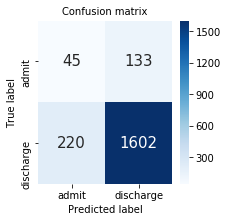

In [238]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

print ('validation set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

training set results
Metrics Report:
---------------
weighted f1:  0.875475094514157
AUROC:        0.7758006568333315
accuracy:     0.866
precision:    [0.345821 0.943814]
recall:       [0.479361 0.906056]
sensitivity:  0.4793608521970706
specificity:  0.9060560077252034
PPV:          0.345821325648415
NPV:          0.9438137663457393


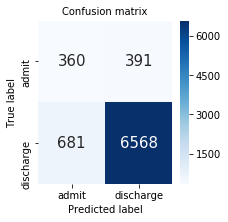

In [239]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

print ('training set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

In [242]:
loss_func = nn.CrossEntropyLoss(weight = tensor([1/9,8/9]))
learn = tabular_learner(data, layers, loss_func = loss_func, metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.159883,0.646269,0.911000,00:51
1,0.074908,0.184517,0.900500,00:49
2,0.068472,0.078476,0.911000,00:47
3,0.069665,0.074774,0.911000,00:47
4,0.064383,0.068573,0.911000,00:47
5,0.064636,0.067933,0.910500,00:48
6,0.063377,0.074092,0.911000,00:48
7,0.061776,0.087018,0.908000,00:48
8,0.058938,0.074397,0.908000,00:48
9,0.057977,0.081284,0.905500,00:48


validation set results
Metrics Report:
---------------
weighted f1:  0.8684877388052158
AUROC:        0.6026915107487759
accuracy:     0.9055
precision:    [0.176471 0.91175 ]
recall:       [0.016854 0.992316]
sensitivity:  0.016853932584269662
specificity:  0.9923161361141603
PPV:          0.17647058823529413
NPV:          0.9117498739283914


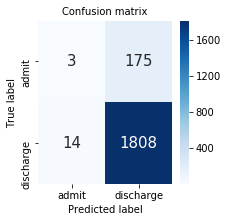

In [243]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

print ('validation set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

training set results
Metrics Report:
---------------
weighted f1:  0.8798736373075625
AUROC:        0.78082334328129
accuracy:     0.914125
precision:    [1.       0.913432]
recall:       [0.08522 1.     ]
sensitivity:  0.085219707057257
specificity:  1.0
PPV:          1.0
NPV:          0.9134324596774194


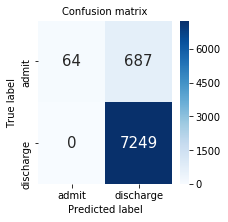

In [244]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

print ('training set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

In [170]:
learn = tabular_learner(data, layers, loss_func = LabelSmoothingCrossEntropy(), metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.429397,1.486234,0.132000,00:56
1,0.403334,0.844755,0.908000,00:59
2,0.392112,0.663933,0.908000,00:58
3,0.389618,0.420111,0.906500,01:01
4,0.380528,0.393690,0.908000,00:59
5,0.379854,0.451027,0.889500,01:02
6,0.370681,0.403593,0.899000,01:01
7,0.368719,0.415142,0.893000,00:55
8,0.363264,0.403593,0.900000,00:56
9,0.357988,0.409024,0.897000,00:55


In [178]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

In [195]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

#### 100000 patients, 1000 diagnoses

In [197]:
test_df = small_findings.sample(100000)
cat_names = list(test_df.columns)[:-1]
dep_var = 'discharge'  

#procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_df.copy(), cat_names=cat_names)

data = (TabularList.from_df(test_df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [199]:
learn = tabular_learner(data, layers, metrics=[accuracy])
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.305677,0.323280,0.900950,08:00
1,0.308844,0.318944,0.896750,08:26
2,0.305925,0.306125,0.899700,08:32
3,0.291029,0.302756,0.900250,08:34
4,0.302242,0.302489,0.900300,08:27


validation set results
Metrics Report:
---------------
weighted f1:  0.8589373678107866
AUROC:        0.6810172392917095
accuracy:     0.9003
precision:    [0.453125 0.90318 ]
recall:       [0.029263 0.996115]
sensitivity:  0.029263370332996974
specificity:  0.9961149961149961
PPV:          0.453125
NPV:          0.9031803542673108


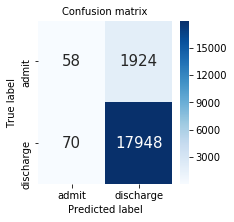

In [200]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

print ('validation set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

training set results
Metrics Report:
---------------
weighted f1:  0.8605585391587469
AUROC:        0.7066838194935212
accuracy:     0.9016625
precision:    [0.520747 0.903971]
recall:       [0.031825 0.996797]
sensitivity:  0.03182452136427032
specificity:  0.9967966940773508
PPV:          0.520746887966805
NPV:          0.9039714278528131


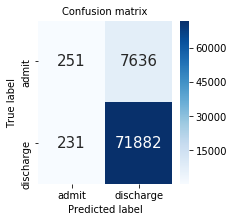

In [201]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

print ('training set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)